<a href="https://colab.research.google.com/github/bordin89/ML4NGP_tutorials/blob/main/ml4ngp_2_profam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🧬 Generating novel sequences and structures with ProFam-1

This notebook presents an end-to-end workflow for **protein sequence generation and structural validation** using **ProFam-1**, a family-aware generative model trained on protein domain and family information. The goal of the workshop is to guide you from an input protein sequence, through controlled generative modelling, to quantitative and visual structural comparison against a reference structure.

The notebook is designed to be fully reproducible in a Google Colab environment with GPU support and does not require Flash Attention. All steps are executed interactively, allowing participants to explore how generative parameters affect sequence quality and downstream structural fidelity.

We begin by setting up the computational environment and installing the required dependencies. The ProFam repository is cloned, and a pretrained ProFam-1 checkpoint is located and prepared for inference. Care is taken to ensure compatibility with standard Colab GPU instances, avoiding optional components that are not universally available.

Next, an input protein sequence is provided. By default, the notebook uses a known PETase sequence from UniProt as a single-sequence prompt, but participants may alternatively paste their own sequence directly into the notebook. Any extraneous whitespace or line breaks are removed automatically, and the sequence is written to FASTA format for downstream use.

Using ProFam-1, one or more novel protein sequences are then generated, conditioned on the input sequence. The generation step exposes a small number of adjustable parameters, such as the number of sequences to generate and the sampling temperature, while keeping most model settings fixed to sensible defaults. Additional quality filters are applied to enforce reasonable sequence lengths and minimum similarity to the prompt, helping to avoid pathological or truncated outputs.

Structure prediction is performed outside the notebook using a tool such as AlphaFold or ESMFold. Once predicted, the structures of both the generated sequence and the original input sequence are uploaded back into the notebook in either PDB or mmCIF format. These structures form the basis for structural validation.

Structural comparison is carried out using **TM-align**, which provides quantitative measures of similarity including TM-score, RMSD, and aligned length. The TM-score is particularly informative: values above 0.5 generally indicate a shared fold, while values above 0.8 suggest strong structural agreement. These metrics allow an objective assessment of whether the generated sequence preserves the overall fold of the reference protein.

Finally, the two structures are superposed and visualised together using **NGLView** in cartoon (ribbon/strand) representation. The generated structure is rigidly transformed onto the reference structure using the rotation matrix produced by TM-align, allowing direct visual inspection of conserved cores, flexible regions, and any structural deviations. This final step helps connect quantitative scores to intuitive, three-dimensional understanding.

By the end of this notebook, you will have walked through a complete generative protein design loop, from sequence generation to structure-based validation, and gained practical insight into how modern protein language models can be evaluated using structural biology tools.

In [2]:
#@title 1) GPU sanity check

import torch, subprocess

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    print("CUDA version (torch):", torch.version.cuda)

# Optional: show nvidia-smi if available
try:
    out = subprocess.check_output(["nvidia-smi"], text=True)
    print("\n" + out[:1500])
except Exception:
    print("nvidia-smi not available")

Torch version: 2.9.0+cu128
CUDA available: True
GPU: Tesla T4
CUDA version (torch): 12.8

Fri Feb 13 17:39:42 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              9W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |       

In [3]:
#@title 2) Clone ProFam

import os, pathlib

BASE_DIR = pathlib.Path("/content").resolve()
WORK_DIR = BASE_DIR / "profam_workshop"
WORK_DIR.mkdir(exist_ok=True)

os.chdir(WORK_DIR)
print("Working directory:", WORK_DIR)

if not (WORK_DIR / "profam").exists():
    !git clone https://github.com/alex-hh/profam.git
else:
    print("ProFam repository already present")

%cd {WORK_DIR / "profam"}
!git rev-parse --short HEAD

Working directory: /content/profam_workshop
Cloning into 'profam'...
remote: Enumerating objects: 8337, done.
remote: Counting objects: 100% (490/490), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 8337 (delta 448), reused 420 (delta 415), pack-reused 7847 (from 3)
Receiving objects: 100% (8337/8337), 1.42 MiB | 4.65 MiB/s, done.
Resolving deltas: 100% (6253/6253), done.
/content/profam_workshop/profam
4f89b22


In [4]:
#@title 3) Install ProFam (GPU runtime, no flash-attn, Colab-friendly)

import re, pathlib, os

repo = pathlib.Path("/content/profam_workshop/profam").resolve()
os.chdir(repo)
print("Repository:", repo)

# Ensure up-to-date build tools
!pip -q install -U pip setuptools wheel

req_in = repo / "requirements.txt"
if not req_in.exists():
    raise FileNotFoundError(f"Missing {req_in}")

# Packages we deliberately do not override in Colab
SKIP_PREFIXES = (
    "flash-attn", "flash_attn",
    "numpy", "pandas", "requests",
    "torch", "torchvision", "torchaudio",
    "jax", "jaxlib",
)

filtered = []
removed = []

for ln in req_in.read_text().splitlines():
    s = ln.strip()
    if not s or s.startswith("#"):
        filtered.append(ln)
        continue

    head = re.split(r"[<>=!\s\[]", s, maxsplit=1)[0].lower()

    if any(head.startswith(p) for p in SKIP_PREFIXES):
        removed.append(ln)
        continue

    filtered.append(ln)

req_out = repo / "requirements.colab_noflash.txt"
req_out.write_text("\n".join(filtered) + "\n")

print(f"Wrote {req_out.name}")

if removed:
    print("Skipped packages:")
    for r in removed:
        print(" ", r)

# Install filtered dependencies
!pip -q install -r requirements.colab_noflash.txt

# Patch common Colab/runtime dependencies
!pip -q install \
    "pandas==2.2.2" \
    "requests==2.32.4" \
    "packaging>=24.2" \
    "typing-extensions>=4.12.0" \
    "xxhash>=3.5.0" \
    "jedi>=0.16"

# Install ProFam in editable mode
!pip -q install -e .

print("ProFam installation complete.")

Repository: /content/profam_workshop/profam
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 72.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
Wrote requirements.colab_noflash.txt
Skipped packages:
  numpy==1.26.4
  pandas==2.3.3
  requests==2.32.2
  torch==2.6.0
  torchvision==0.21.0
  torchaudio==2.6.0
  torchmetrics==1.8.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
diffusers 0.36.0 requires huggingface-hub<2.0,>=0.34.0, but you have huggingface-hub 0.24.6 which is incompatible.
xarray 2025.12.0 requires packag

In [5]:
#@title 4) Download ProFam model checkpoint from Hugging Face

import os, pathlib

repo = pathlib.Path("/content/profam_workshop/profam").resolve()
os.chdir(repo)

os.environ["HF_HOME"] = "/content/hf_cache"
pathlib.Path(os.environ["HF_HOME"]).mkdir(exist_ok=True, parents=True)

!python scripts/hf_download_checkpoint.py

print("Checkpoint download complete.")

Fetching 5 files:   0% 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:1212: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(

.gitattributes: 1.52kB [00:00, 1.49MB/s]
Fetching 5 files:  20% 1/5 [00:00<00:00,  5.34it/s]
last.ckpt:   0% 0.00/1.51G [00:00<?, ?B/s]

README.md: 100% 24.0/24.0 [00:00<00:00, 115kB/s]


config.yaml: 13.3kB [00:00, 26.4MB/s]
Fetching 5 files:  40% 2/5 [00:00<00:00,  7.18it/s]
last.ckpt:   1% 21.0M/1.51G [00:00<00:10, 137MB/s]

gym_config.yaml: 6.55kB [00:00, 16.5MB/s]

last.ckpt:   3% 52.4M/1.51G [00:00<00:06, 209MB/s]
last.ckpt:   6% 83.9M/1.51G [00:00<00:05, 246MB/s]
last.ckpt:   8

In [6]:
#@title 5) Fix Colab torch/torchvision mismatch (remove torchvision)

# Remove torchvision to prevent torchmetrics/lightning import issues
!pip -q uninstall -y torchvision || true

print("torchvision removed.")

torchvision removed.


In [7]:
#@title 6) Show ProFam CLI help (score + generate)

import pathlib, os

repo = pathlib.Path("/content/profam_workshop/profam").resolve()
os.chdir(repo)

print("=== score_sequences.py ===")
!python scripts/score_sequences.py -h | head -n 120

print("\n=== generate_sequences.py ===")
!python scripts/generate_sequences.py -h | head -n 120

=== score_sequences.py ===
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]
/usr/local/lib/python3.12/dist-packages/lightning_utilities/core/imports.py:14: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2026-02-13 17:45:09.079314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771004709.268527    2700 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been reg

In [8]:
#@title 7) Create prompt FASTA (default PETase or user-provided sequence)

import pathlib, textwrap, re, os

repo = pathlib.Path("/content/profam_workshop/profam").resolve()
os.chdir(repo)

# -----------------------------------------------------------------------------
# DISCLAIMER
# -----------------------------------------------------------------------------
# ProFam can also take a multi-sequence FASTA or an aligned MSA (e.g. A3M).
#
# - A single sequence is sufficient and recommended for sequence generation.
# - Multiple FASTA entries are treated as independent prompts.
# - Providing an MSA can be used to condition generation on a protein family,
#   but alignment is NOT required for generation.
# - MSAs are primarily important for variant scoring, not for generation.
#
# For this workshop, we use a single-sequence prompt by default.
# -----------------------------------------------------------------------------

# =========================
# USER CHOICES
# =========================
USE_DEFAULT = True  #@param {type:"boolean"}

# If USE_DEFAULT = False, paste either:
#  - FASTA (one or more records), OR
#  - a raw amino-acid sequence
USER_SEQUENCE_TEXT = "MNKFLALALAVSLSASAAPVPSQAFGDLGKDTVAV GDSGVPVSPQTDPSATVGRRLTAAALDALDAGADVV VPGSAGTFSVTLGATNATVVGVDLQLAGADATVTLA AGATGNSGGYVVWGGHGTQATQVVAGLPQLAVAGAD VVIVDNNRAGADVVAVSGGTTSTTTW"  #@param {type:"string"}

USER_SEQ_NAME = "TEST"  #@param {type:"string"}

out_fa = repo / "prompts.fasta"

# =========================
# DEFAULT: PETase (Ideonella sakaiensis)
# UniProt: QRG82925
# =========================
DEFAULT_FASTA = textwrap.dedent("""\
>PETase_A0A0K8P6T7
MNFPRASRLMQAAVLGGLMAVSAAATAQTNPYARGPNPTAASLEASAGPFTVRSFTVSRP
SGYGAGTVYYPTNAGGTVGAIAIVPGYTARQSSIKWWGPRLASHGFVVITIDTNSTLDQP
SSRSSQQMAALRQVASLNGTSSSPIYGKVDTARMGVMGWSMGGGGSLISAANNPSLKAAA
PQAPWDSSTNFSSVTVPTLIFACENDSIAPVNSSALPIYDSMSRNAKQFLEINGGSHSCA
NSGNSNQALIGKKGVAWMKRFMDNDTRYSTFACENPNSTRVSDFRTANCS
""")

AA_RE = re.compile(r"^[ACDEFGHIKLMNPQRSTVWYBXZJUO\-\.\s]+$", re.IGNORECASE)

def normalize_raw_sequence(s: str) -> str:
    """
    Accept raw amino-acid sequences that may contain spaces or newlines.
    Strip everything except letters A–Z and uppercase.
    """
    s = s.strip().upper()
    s = re.sub(r"\s+", "", s)
    s = re.sub(r"[^A-Z]", "", s)
    return s

def to_fasta_from_raw(seq: str, name: str) -> str:
    seq = normalize_raw_sequence(seq)
    if not seq:
        raise ValueError("Sequence is empty after cleaning.")
    wrapped = "\n".join(seq[i:i+60] for i in range(0, len(seq), 60))
    return f">{name}\n{wrapped}\n"

def is_fasta(txt: str) -> bool:
    return txt.lstrip().startswith(">")

# =========================
# WRITE FASTA
# =========================
if USE_DEFAULT:
    out_fa.write_text(DEFAULT_FASTA)
    print("Using default PETase sequence (UniProt QRG82925)")
else:
    txt = (USER_SEQUENCE_TEXT or "").strip()
    if not txt:
        raise ValueError("USE_DEFAULT is False but USER_SEQUENCE_TEXT is empty.")

    if is_fasta(txt):
        out_fa.write_text(txt.strip() + "\n")
        print("Using user-provided FASTA (single or multiple sequences)")
    else:
        if not AA_RE.match(txt.replace("\n", "")):
            raise ValueError("Input is neither FASTA nor a valid amino-acid sequence.")
        out_fa.write_text(to_fasta_from_raw(txt, USER_SEQ_NAME))
        print("Using user-provided raw sequence")

print("\nNote:")
print("This FASTA can contain a single sequence, multiple sequences, or an MSA.")
print("For generation, alignment is optional; for scoring, MSAs are recommended.")

print("\n--- prompts.fasta ---")
print(out_fa.read_text())

Using default PETase sequence (UniProt QRG82925)

Note:
This FASTA can contain a single sequence, multiple sequences, or an MSA.
For generation, alignment is optional; for scoring, MSAs are recommended.

--- prompts.fasta ---
>PETase_A0A0K8P6T7
MNFPRASRLMQAAVLGGLMAVSAAATAQTNPYARGPNPTAASLEASAGPFTVRSFTVSRP
SGYGAGTVYYPTNAGGTVGAIAIVPGYTARQSSIKWWGPRLASHGFVVITIDTNSTLDQP
SSRSSQQMAALRQVASLNGTSSSPIYGKVDTARMGVMGWSMGGGGSLISAANNPSLKAAA
PQAPWDSSTNFSSVTVPTLIFACENDSIAPVNSSALPIYDSMSRNAKQFLEINGGSHSCA
NSGNSNQALIGKKGVAWMKRFMDNDTRYSTFACENPNSTRVSDFRTANCS



In [9]:
#@title 8) Locate ProFam checkpoint_dir

import pathlib, os

repo = pathlib.Path("/content/profam_workshop/profam").resolve()
os.chdir(repo)

candidates = []

# Look inside the repository
for p in pathlib.Path(".").rglob(".hydra"):
    candidates.append(p.parent)

# Look in Hugging Face cache
hf_home = pathlib.Path(os.environ.get("HF_HOME", "/content/hf_cache"))
if hf_home.exists():
    for p in hf_home.rglob(".hydra"):
        candidates.append(p.parent)

# De-duplicate
uniq = []
seen = set()
for c in candidates:
    c = c.resolve()
    if c not in seen:
        seen.add(c)
        uniq.append(c)

if not uniq:
    raise RuntimeError(
        "Could not find a checkpoint directory containing '.hydra'. "
        "Run the checkpoint download cell first."
    )

# Select the most recent checkpoint
checkpoint_dir = sorted(uniq, key=lambda x: x.stat().st_mtime, reverse=True)[0]
print("Using checkpoint_dir:", checkpoint_dir)

Using checkpoint_dir: /content/profam_workshop/profam/model_checkpoints/profam-1


# Generate Sequences using ProFam-1

In this section, we use **ProFam-1**, a protein family–aware generative model, to generate new protein sequences from a single input sequence.

The model conditions on the input sequence and samples novel sequences that are consistent with the learned protein family constraints.

**Notes for the workshop:**
- The generation runs on **GPU** if available.
- **Flash Attention is disabled** for compatibility with Google Colab.
- Output sequences will be written as FASTA files in the `generated/` directory.



> **Runtime & Resource Notice**
>
> - Sequence generation may take **1–3 minutes** on a Google Colab GPU.
> - The first run may be slightly slower due to **model weight loading**.
> - If you see CUDA or cuDNN warnings, these are expected and can be ignored.
>
> If the notebook appears idle, please wait — the model is still running.

## Generation Parameters

The sequence generation step uses probabilistic sampling. The key parameters are:

| Parameter | Meaning |
|---------|--------|
| `temperature` | Controls randomness. Lower = more conservative, higher = more diverse |
| `top_p` | Nucleus sampling threshold (keeps top probability mass) |
| `num_samples` | Number of sequences generated per prompt |
| `max_tokens` | Maximum total tokens generated |
| `sampler` | `ensemble` uses multiple internal prompts for robustness |
| `device` | `cuda` uses GPU if available |
| `dtype` | `float16` reduces memory usage on GPU |
| `attn_implementation` | `sdpa` is used instead of Flash Attention for Colab compatibility |

**Tip:**  
For more diversity, increase `temperature` (e.g. `1.2`).  
For safer, more conservative sequences, decrease it (e.g. `0.8`).

In [10]:
#@title 9) Install MMseqs2 (required for --minimum_sequence_identity filtering)

import os, pathlib

WORK_DIR = pathlib.Path("/content/profam_workshop").resolve()
mmseqs_dir = WORK_DIR / "mmseqs"
mmseqs_bin = mmseqs_dir / "bin" / "mmseqs"

# Clean and install
!rm -rf "{mmseqs_dir}"
!mkdir -p "{mmseqs_dir}"
!wget -q https://mmseqs.com/latest/mmseqs-linux-avx2.tar.gz -O /tmp/mmseqs.tar.gz
!tar -xzf /tmp/mmseqs.tar.gz -C "{mmseqs_dir}" --strip-components=1
!rm /tmp/mmseqs.tar.gz

# Add to PATH
os.environ["PATH"] = f"{mmseqs_dir}/bin:" + os.environ["PATH"]

print("mmseqs binary:", mmseqs_bin)
!{mmseqs_bin} version

mmseqs binary: /content/profam_workshop/mmseqs/bin/mmseqs
01683a607f83878e95436632d73e1d7d9ae30955


In [11]:
#@title 10) Device & dtype selection (GPU with safe fallback)

import torch

# Preferred defaults (workshop intent)
PREFERRED_DEVICE = "cuda"
PREFERRED_DTYPE  = "float16"

if torch.cuda.is_available():
    device = PREFERRED_DEVICE
    dtype  = PREFERRED_DTYPE
    gpu_name = torch.cuda.get_device_name(0)
    print(f"Using GPU: {gpu_name}")
else:
    device = "cpu"
    dtype  = "float32"
    print(
        "No NVIDIA GPU detected.\n"
        "Falling back to CPU (this will be slower, but functional)."
    )

print(f"device = {device}")
print(f"dtype  = {dtype}")

Using GPU: Tesla T4
device = cuda
dtype  = float16


In [12]:
#@title 11) Generate sequences with ProFam-1

import pathlib, os, shutil
import torch

# ---------------- User parameters ----------------
num_sequences = 10  #@param {type:"integer", min:1, max:50, step:1}
temperature   = 0.8  #@param {type:"number", min:0.5, max:1.5, step:0.1}

max_tokens = 2048  #@param {type:"integer", min:256, max:8192, step:256}
max_generated_length = 512  #@param {type:"integer", min:64, max:4096, step:64}

min_seq_len_prop = 0.8   #@param {type:"number", min:0.5, max:1.0, step:0.05}
max_len_mult     = 1.2   #@param {type:"number", min:1.0, max:2.0, step:0.1}
min_seq_identity = 0.8   #@param {type:"number", min:0.0, max:0.9, step:0.05}

# ---------------- Fixed workshop defaults ----------------
top_p      = 0.95
sampler    = "ensemble"
attn_impl  = "sdpa"   # no flash-attn
seed       = 1

# ---------------- Auto device / dtype ----------------
if torch.cuda.is_available():
    device = "cuda"
    dtype  = "float16"
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = "cpu"
    dtype  = "float32"
    print("No GPU detected; using CPU (slower).")

# ---------------- Paths ----------------
repo = pathlib.Path("/content/profam_workshop/profam").resolve()
os.chdir(repo)

prompt_fa = repo / "prompts.fasta"
save_dir  = repo / "generated"

if not prompt_fa.exists():
    raise FileNotFoundError("prompts.fasta not found. Run the prompt FASTA cell first.")

if "checkpoint_dir" not in globals():
    raise RuntimeError("checkpoint_dir not set. Run the checkpoint discovery cell first.")

# Overwrite previous results
if save_dir.exists():
    shutil.rmtree(save_dir)
save_dir.mkdir(exist_ok=True)

# ---------------- Run generation ----------------
cmd = (
    f"python scripts/generate_sequences.py "
    f"--checkpoint_dir '{checkpoint_dir}' "
    f"--file_path '{prompt_fa}' "
    f"--save_dir '{save_dir}' "
    f"--sampler {sampler} "
    f"--num_prompts_in_ensemble 1 "
    f"--num_samples {num_sequences} "
    f"--max_tokens {max_tokens} "
    f"--max_generated_length {max_generated_length} "
    f"--temperature {temperature} "
    f"--top_p {top_p} "
    f"--device {device} "
    f"--dtype {dtype} "
    f"--attn_implementation {attn_impl} "
    f"--minimum_sequence_length_proportion {min_seq_len_prop} "
    f"--max_sequence_length_multiplier {max_len_mult} "
    f"--seed {seed}"
)

# Only enable identity filter when mmseqs exists
mmseqs_ok = shutil.which("mmseqs") is not None
if mmseqs_ok:
    cmd += f" --minimum_sequence_identity {min_seq_identity}"
else:
    print("mmseqs not found in PATH; skipping --minimum_sequence_identity filtering.")

print("\nCommand:\n", cmd, "\n")
!bash -lc "{cmd}"

print("\nGenerated files:")
!ls -lh "{save_dir}" | head -n 50

Using GPU: Tesla T4

Command:
 python scripts/generate_sequences.py --checkpoint_dir '/content/profam_workshop/profam/model_checkpoints/profam-1' --file_path '/content/profam_workshop/profam/prompts.fasta' --save_dir '/content/profam_workshop/profam/generated' --sampler ensemble --num_prompts_in_ensemble 1 --num_samples 10 --max_tokens 2048 --max_generated_length 512 --temperature 0.8 --top_p 0.95 --device cuda --dtype float16 --attn_implementation sdpa --minimum_sequence_length_proportion 0.8 --max_sequence_length_multiplier 1.2 --seed 1 --minimum_sequence_identity 0.8 

/usr/local/lib/python3.12/dist-packages/lightning_utilities/core/imports.py:14: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2026-02-13 17:45:50.448948: E external/local_xla/xla/stream_executor/cuda/cu

In [13]:
#@title 12) Preview generated FASTA (first file)

import pathlib

repo = pathlib.Path("/content/profam_workshop/profam").resolve()
save_dir = repo / "generated"

fasta_files = sorted(save_dir.glob("*.fa*"))
if not fasta_files:
    raise RuntimeError("No FASTA files found in generated/. Run the generation cell first.")

fp = fasta_files[0]
print("Showing:", fp, "\n")
print("\n".join(fp.read_text().splitlines()[:120]))

Showing: /content/profam_workshop/profam/generated/prompts_generated_ensemble.fasta 

>prompts_sample_0_log_likelihood_-0.490
MRRLTGASSALLAAALAAPALAQAPAPVAAAPAPRTAQAARERTAAGLTFPAGARLTEAAVLPDGPGPFPVRAYAVARPSGYGAGTVYYPADAGGPVGAIAIVPGYTARQSSIKWWGPRLASHGFVVVTIDTNSTLDQPSSRSAQQMAALRQVASLNGTSSSPIYGKVDTARIGVMGWSMGGGGSLISAANNPSLKAAAPQAPWDSSTNFSSVTVPTLIFACENDSIAPVNSSALPIYDSMSRNAKQFLEINGGSHSCANSGNSNQALIGKKGVAWMKRFMDNDTRYSTFACENPNSTRVSDFRTANCS
>prompts_sample_1_log_likelihood_-0.151
MVGGALLAAPLALAQADPYAKAPNPTAASLEASAGPFTVRSFTVSRPAGYGAGTVYYPTNAGGTVGAIAIVPGYTARQSSIKWWGPRLASHGFVVITIDTNSTLDQPSSRSSQQMAALRQVASLNGTSSSPIYGKVDTARMGVMGWSMGGGGSLISAANNPSLKAAAPQAPWDSSTNFSSVTVPTLIFACENDSIAPVNSSALPIYDSMSRNAKQFLEINGGSHSCANSGNSNQALIGKKGVAWMKRFMDNDTRYSTFACENPNSTRVSDFRTANCS
>prompts_sample_2_log_likelihood_-0.792
MRLALIFLSLLSLTACSTTKVLERDAADVRVLTATRLAGYPAGTVYYPVGPGGPVGAVVIVPGYSSSPSDISWWGERLAAHGFVVLTVSTNTTLDQPGSRATQQMRALQQVASANGTSSAPIYGHVDTARLGVMGWSMGGGGALIAASTNPSLKAAAPQAPWDSSTNFSSVTVPTLIFACENDTIAPVNSSALPIYDSMSRNAKQF

In [14]:
#@title 13) Rank generated sequences and pick the best candidate

import pathlib, re
import pandas as pd

repo = pathlib.Path("/content/profam_workshop/profam").resolve()
prompt_fa = repo / "prompts.fasta"
gen_dir = repo / "generated"
out_best = repo / "best_generated.fasta"

if not prompt_fa.exists():
    raise FileNotFoundError("prompts.fasta not found.")
if not gen_dir.exists():
    raise FileNotFoundError("generated/ directory not found. Run generation first.")

AA = set("ACDEFGHIKLMNPQRSTVWYBXZJUO")

def read_fasta(path: pathlib.Path):
    records = []
    name, seq = None, []
    for line in path.read_text().splitlines():
        line = line.strip()
        if not line:
            continue
        if line.startswith(">"):
            if name is not None:
                records.append((name, "".join(seq)))
            name = line[1:].strip()
            seq = []
        else:
            seq.append(line)
    if name is not None:
        records.append((name, "".join(seq)))
    return records

def clean_seq(s: str) -> str:
    s = re.sub(r"\s+", "", s).upper()
    return "".join(c for c in s if c.isalpha())

def longest_run_fraction(s: str) -> float:
    if not s:
        return 0.0
    best = 1
    cur = 1
    for i in range(1, len(s)):
        if s[i] == s[i - 1]:
            cur += 1
            if cur > best:
                best = cur
        else:
            cur = 1
    return best / len(s)

def kmer_low_complexity(s: str, k: int = 3) -> float:
    if len(s) < k + 1:
        return 0.0
    kmers = [s[i:i + k] for i in range(len(s) - k + 1)]
    return 1.0 - (len(set(kmers)) / len(kmers))

def identity_to_prompt(g: str, p: str) -> float:
    n = min(len(g), len(p))
    if n == 0:
        return 0.0
    matches = sum(1 for i in range(n) if g[i] == p[i])
    return matches / n

prompt_records = read_fasta(prompt_fa)
if not prompt_records:
    raise RuntimeError("No FASTA records found in prompts.fasta.")
prompt_name, prompt_seq = prompt_records[0][0], clean_seq(prompt_records[0][1])

rows = []
for fp in sorted(gen_dir.glob("*.fa*")):
    for name, seq in read_fasta(fp):
        seq = clean_seq(seq)
        if not seq:
            continue
        if any(c not in AA for c in seq):
            continue

        rows.append(
            {
                "file": fp.name,
                "id": name,
                "length": len(seq),
                "len_ratio_to_prompt": len(seq) / max(1, len(prompt_seq)),
                "prefix_identity_to_prompt": identity_to_prompt(seq, prompt_seq),
                "longest_run_frac": longest_run_fraction(seq),
                "kmer_low_complexity": kmer_low_complexity(seq, k=3),
                "seq": seq,
            }
        )

if not rows:
    raise RuntimeError("No generated sequences found/parsed in generated/.")

df = pd.DataFrame(rows)

target_min_id = 0.20
target_max_id = 0.60

def rank_score(r):
    len_pen = abs(r["len_ratio_to_prompt"] - 1.0)

    idv = r["prefix_identity_to_prompt"]
    if idv < target_min_id:
        id_pen = (target_min_id - idv) * 2.0
    elif idv > target_max_id:
        id_pen = (idv - target_max_id) * 2.0
    else:
        id_pen = 0.0

    rep_pen = r["kmer_low_complexity"] * 1.5 + r["longest_run_frac"] * 2.0

    return len_pen + id_pen + rep_pen

df["rank_score"] = df.apply(rank_score, axis=1)
df_sorted = df.sort_values("rank_score", ascending=True).reset_index(drop=True)

display_cols = [
    "file",
    "id",
    "length",
    "len_ratio_to_prompt",
    "prefix_identity_to_prompt",
    "kmer_low_complexity",
    "longest_run_frac",
    "rank_score",
]
display(df_sorted[display_cols].head(15))

best = df_sorted.iloc[0]
best_id = best["id"]
best_seq = best["seq"]

wrapped = "\n".join(best_seq[i:i + 60] for i in range(0, len(best_seq), 60))
out_best.write_text(f">{best_id}\n{wrapped}\n")

print("Recommended sequence:")
print("  ID:", best_id)
print("  Length:", len(best_seq))
print("  Score:", float(best["rank_score"]))
print("  Saved:", out_best)

,file,id,length,len_ratio_to_prompt,prefix_identity_to_prompt,kmer_low_complexity,longest_run_frac,rank_score
0,prompts_generated_ensemble.fasta,prompts_sample_6_log_likelihood_-0.459,289,0.996552,0.128028,0.069686,0.013841,0.279604
1,prompts_generated_ensemble.fasta,prompts_sample_5_log_likelihood_-0.363,289,0.996552,0.107266,0.048780,0.013841,0.289768
2,prompts_generated_ensemble.fasta,prompts_sample_8_log_likelihood_-0.361,289,0.996552,0.107266,0.052265,0.013841,0.294994
3,prompts_generated_ensemble.fasta,prompts_sample_9_log_likelihood_-0.350,289,0.996552,0.117647,0.080139,0.017301,0.322965
4,prompts_generated_ensemble.fasta,prompts_sample_1_log_likelihood_-0.151,277,0.955172,0.090253,0.043636,0.014440,0.358658
5,prompts_generated_ensemble.fasta,prompts_sample_3_log_likelihood_-0.511,284,0.979310,0.080986,0.053191,0.014085,0.366674
6,prompts_generated_ensemble.fasta,prompts_sample_7_log_likelihood_-0.399,282,0.972414,0.078014,0.057143,0.014184,0.385641
7,prompts_generated_ensemble.fasta,prompts_sample_0_log_likelihood_-0.490,309,1.065517,0.082759,0.084691,0.012945,0.452926
8,prompts_generated_ensemble.fasta,prompts_sample_2_log_likelihood_-0.792,267,0.920690,0.067416,0.060377,0.014981,0.465007
9,prompts_generated_ensemble.fasta,prompts_sample_4_log_likelihood_-0.247,278,0.958621,0.064748,0.094203,0.017986,0.489158


Recommended sequence:
  ID: prompts_sample_6_log_likelihood_-0.459
  Length: 289
  Score: 0.2796041901646623
  Saved: /content/profam_workshop/profam/best_generated.fasta


In [15]:
!cat /content/profam_workshop/profam/best_generated.fasta

>prompts_sample_6_log_likelihood_-0.459
MGHRRFGFRLRAAAASLLLGSSLLASLPAAAQGTPSSGTGAPAGASPAVTVRAFSTVRPG
GFGAGTVYYPAAAGGAVGAIAIVPGYTARQSSIKWWGPRLASHGFVVVTIDTNSTLDQPS
SRSSQQMAALRQVASLNGTSSSPIYGKVDTARMGVMGWSMGGGGSLISAANNPSLKAAAP
QAPWDSSTNFSSVTVPTLIFACENDSIAPVNSSALPIYDSMSRNAKQFLEINGGSHSCAN
SGNSNQALIGKKGVAWMKRFMDNDTRYSTFACENPNSTRVSDFRTANCS


# Once you reach this step, kill the next cell. Select the best ranked sequence from the previous cell and go to Colabfold and start modelling your sequence with AF2. Once done, retrieve the AFDB mmCIF structure of isPETase from https://www.alphafold.ebi.ac.uk/entry/AF-A0A0K8P6T7-F1 , run the next cell and upload both structures. Continue the notebook from the next cell. WARNING: THIS WILL DISCONNECT YOUR NOTEBOOK. For the sake of this workshop you can choose to re-run the notebook from the top and upload the structures, or skip the next two cells.

In [16]:
#@title 14) Upload two structures for TM-score and visualisation

from google.colab import files
from pathlib import Path

UPLOAD_DIR = Path("/content/tmalign_uploads")
UPLOAD_DIR.mkdir(exist_ok=True)

def upload_one(label):
    print(f"\nUpload {label} (PDB .pdb/.ent or mmCIF .cif/.mmcif)")
    uploaded = files.upload()

    if len(uploaded) != 1:
        raise RuntimeError(
            f"{label}: Please upload exactly one file (got {len(uploaded)}). "
            "Re-run the cell."
        )

    name, data = next(iter(uploaded.items()))
    dst = UPLOAD_DIR / name

    with open(dst, "wb") as f:
        f.write(data)

    print(f"{label} saved to: {dst}")
    return str(dst)

# Upload structure A
struct_a = upload_one("Structure A (e.g. ProFam-generated model)")

# Upload structure B
struct_b = upload_one("Structure B (e.g. AFDB or reference structure)")

print("\nStructures ready for TM-score:")
print("  Structure A:", struct_a)
print("  Structure B:", struct_b)
print("\nRun the TM-score alignment cell next.")


Upload Structure A (e.g. ProFam-generated model) (PDB .pdb/.ent or mmCIF .cif/.mmcif)


KeyboardInterrupt: 

In [ ]:
#@title TM-align: align A vs B, report TM-score, and visualise superposition (single output)

import re, subprocess
from pathlib import Path

SHOW_3DMOL = False  #@param {type:"boolean"}  # If True, shows 3Dmol output before NGLView

# --- Inputs from upload cells ------------------------------------------------
if "struct_a" not in globals() or "struct_b" not in globals():
    raise RuntimeError("struct_a / struct_b not set. Run the upload cell first.")

struct_a = str(struct_a)
struct_b = str(struct_b)

chain_a = ""  #@param {type:"string"}  # leave blank = first chain
chain_b = ""  #@param {type:"string"}  # leave blank = first chain

WORK_DIR = Path("/content/tmalign_work").resolve()
WORK_DIR.mkdir(exist_ok=True)

# Install deps (quiet)
!pip -q install gemmi nglview
if SHOW_3DMOL:
    !pip -q install py3Dmol

# Enable widget manager for NGLView in Colab
from google.colab import output
output.enable_custom_widget_manager()

import gemmi
import nglview as nv

def ensure_tmalign(bin_path: Path) -> Path:
    if bin_path.exists():
        return bin_path
    bin_path.parent.mkdir(parents=True, exist_ok=True)
    url = "https://zhanggroup.org/TM-align/TMalign"
    subprocess.run(["bash", "-lc", f"wget -q '{url}' -O '{bin_path}'"], check=True)
    subprocess.run(["bash", "-lc", f"chmod +x '{bin_path}'"], check=True)
    return bin_path

TMALIGN = ensure_tmalign(WORK_DIR / "bin" / "TMalign")

def first_chain_id(path: str) -> str:
    st = gemmi.read_structure(path)
    for model in st:
        for ch in model:
            return ch.name
    return ""

def to_pdb(in_path: str, out_path: Path, chain_id: str = "") -> Path:
    st = gemmi.read_structure(str(in_path))
    if chain_id.strip():
        keep = chain_id.strip()
        for model in st:
            for ch in list(model):
                if ch.name != keep:
                    model.remove_chain(ch.name)
        st.remove_empty_chains()
    st.write_pdb(str(out_path))
    return out_path

# Choose default chains if blank
if chain_a.strip() == "":
    chain_a = first_chain_id(struct_a)
if chain_b.strip() == "":
    chain_b = first_chain_id(struct_b)

# Prepare inputs
pdb_a = WORK_DIR / "A.pdb"
pdb_b = WORK_DIR / "B.pdb"
to_pdb(struct_a, pdb_a, chain_a)
to_pdb(struct_b, pdb_b, chain_b)

# --- Run TM-align with matrix output -----------------------------------------
matrix_file = WORK_DIR / "tmalign_matrix.txt"
if matrix_file.exists():
    matrix_file.unlink()

res = subprocess.run(
    [str(TMALIGN), str(pdb_a), str(pdb_b), "-m", str(matrix_file)],
    capture_output=True, text=True
)
out = (res.stdout or "") + "\n" + (res.stderr or "")
if res.returncode != 0:
    print(out)
    raise RuntimeError(f"TM-align failed with exit code {res.returncode}")

# --- Parse summary ------------------------------------------------------------
tm_scores = [float(x) for x in re.findall(r"TM-score=\s*([0-9]*\.[0-9]+)", out)]
rmsd_m = re.search(r"RMSD=\s*([0-9]*\.[0-9]+)", out)
aln_m  = re.search(r"Aligned length=\s*(\d+)", out)

print("TM-align summary")
print("  A:", Path(struct_a).name, f"(chain {chain_a})")
print("  B:", Path(struct_b).name, f"(chain {chain_b})")
if aln_m:
    print(f"  Aligned length: {int(aln_m.group(1))}")
if rmsd_m:
    print(f"  RMSD: {float(rmsd_m.group(1)):.3f}")
if tm_scores:
    if len(tm_scores) >= 2:
        print(f"  TM-score (norm by A length): {tm_scores[0]:.5f}")
        print(f"  TM-score (norm by B length): {tm_scores[1]:.5f}")
        print(f"  TM-score (max): {max(tm_scores[0], tm_scores[1]):.5f}")
    else:
        print(f"  TM-score: {tm_scores[0]:.5f}")
print()

# --- Robust parse of 3x4 matrix from -m file ---------------------------------
if not matrix_file.exists() or matrix_file.stat().st_size == 0:
    raise RuntimeError("TM-align did not create a matrix file. Something went wrong with -m.")

lines = [ln.strip() for ln in matrix_file.read_text().splitlines() if ln.strip()]

rows = {}
for ln in lines:
    parts = ln.split()
    if len(parts) >= 5 and parts[0] in ("1", "2", "3"):
        m = int(parts[0])
        rows[m] = [float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])]

if not all(k in rows for k in (1, 2, 3)):
    raise RuntimeError(
        "Could not parse the 3 rotation-matrix rows from TM-align -m output.\n"
        "First 30 non-empty lines:\n" + "\n".join(lines[:30])
    )

t = [rows[1][0], rows[2][0], rows[3][0]]
U = [
    [rows[1][1], rows[1][2], rows[1][3]],
    [rows[2][1], rows[2][2], rows[2][3]],
    [rows[3][1], rows[3][2], rows[3][3]],
]

# TM-align: X2 = t + U * x1  (Chain_1 -> Chain_2)
# We want to move B onto A => apply inverse transform to B:
UT = [
    [U[0][0], U[1][0], U[2][0]],
    [U[0][1], U[1][1], U[2][1]],
    [U[0][2], U[1][2], U[2][2]],
]
t_inv = [
    -(UT[0][0]*t[0] + UT[0][1]*t[1] + UT[0][2]*t[2]),
    -(UT[1][0]*t[0] + UT[1][1]*t[1] + UT[1][2]*t[2]),
    -(UT[2][0]*t[0] + UT[2][1]*t[1] + UT[2][2]*t[2]),
]

M_inv = [
    UT[0][0], UT[0][1], UT[0][2], t_inv[0],
    UT[1][0], UT[1][1], UT[1][2], t_inv[1],
    UT[2][0], UT[2][1], UT[2][2], t_inv[2],
    0,        0,        0,        1
]

# --- Write B superposed onto A (for NGLView) ---------------------------------
B_SUP = WORK_DIR / "B_superposed.pdb"

def apply_transform_to_structure(in_pdb: Path, out_pdb: Path, M):
    st = gemmi.read_structure(str(in_pdb))
    r11,r12,r13,t1, r21,r22,r23,t2, r31,r32,r33,t3, _,_,_,_ = M
    for model in st:
        for chain in model:
            for res in chain:
                for atom in res:
                    x,y,z = atom.pos.x, atom.pos.y, atom.pos.z
                    X = t1 + r11*x + r12*y + r13*z
                    Y = t2 + r21*x + r22*y + r23*z
                    Z = t3 + r31*x + r32*y + r33*z
                    atom.pos = gemmi.Position(X, Y, Z)
    st.write_pdb(str(out_pdb))

apply_transform_to_structure(pdb_b, B_SUP, M_inv)

# --- Optional: 3Dmol (only if requested) -------------------------------------
if SHOW_3DMOL:
    import py3Dmol
    v3 = py3Dmol.view(width=900, height=520)
    v3.addModel(pdb_a.read_text(), "pdb")
    v3.addModel(pdb_b.read_text(), "pdb")
    v3.setTransform({"model": 1}, M_inv)
    v3.setStyle({"model": 0}, {"cartoon": {"color": "dodgerblue"}})
    v3.setStyle({"model": 1}, {"cartoon": {"color": "tomato", "opacity": 0.70}})
    v3.zoomTo()
    v3  # render as output (no .show())

# Superposition viewer (NGLView, force uniform colors; defeat rainbow defaults)

from google.colab import output
output.enable_custom_widget_manager()

!pip -q install nglview gemmi

import nglview as nv
from pathlib import Path

WORK_DIR = Path("/content/tmalign_work").resolve()
pdb_a = WORK_DIR / "A.pdb"
b_sup = WORK_DIR / "B_superposed.pdb"

if not pdb_a.exists():
    raise FileNotFoundError(pdb_a)
if not b_sup.exists():
    raise FileNotFoundError(b_sup)

view = nv.NGLWidget()

# Add components
compA = view.add_component(str(pdb_a))
compB = view.add_component(str(b_sup))

compA.clear_representations()
compB.clear_representations()


compA.add_cartoon(colorScheme="uniform", color="red")
compB.add_cartoon(colorScheme="uniform", color="blue", opacity=0.7)

view.center()
view

## Variant Scoring with ProFam-1 using ProteinGym DMS Data

In this section, we demonstrate ProFam-1’s **variant scoring** capability using experimental Deep Mutational Scanning (DMS) data from the ProteinGym benchmark.

Unlike sequence generation, variant scoring evaluates how well the model ranks mutated protein sequences relative to experimentally measured functional effects.

### Concept

ProFam scoring requires two inputs:

- **conditioning_fasta**  
  A sequence or multiple sequences representing the functional family context.  
  This can be:
  - The wild-type (WT) sequence only
  - A small set of homologous functional variants
  - A full MSA (optional, but improves family conditioning)

- **candidates_file**  
  A FASTA file containing mutated variants to score and rank.

### Workflow Overview

1. Download a ProteinGym DMS dataset.
2. Extract the UniProt identifier from the filename.
3. Retrieve the wild-type sequence from UniProt.
4. Create:
   - `conditioning.fasta` (WT or small family set)
   - `candidates.fasta` (mutant sequences from DMS)
5. Run `score_sequences.py`.
6. Compare ProFam scores with experimental DMS measurements (e.g., Spearman correlation).

This demonstrates how ProFam can be used to rank variants by predicted fitness and assess how well model likelihood correlates with real experimental data.

In [27]:
#@title 📂 Select a ProteinGym DMS dataset

import pathlib
import ipywidgets as widgets
from IPython.display import display

BASE_DIR = pathlib.Path("/content/proteingym").resolve()

csv_files = sorted(BASE_DIR.rglob("*.csv"))

if not csv_files:
    raise RuntimeError("No CSV files found. Run the download cell first.")

file_dict = {p.name: str(p) for p in csv_files}

dropdown = widgets.Dropdown(
    options=sorted(file_dict.keys()),
    description="Dataset:",
    layout=widgets.Layout(width="70%"),
)

output = widgets.Output()

selected_file_path = file_dict[dropdown.value]

def on_change(change):
    global selected_file_path
    selected_file_path = file_dict[change["new"]]
    with output:
        output.clear_output()
        print("Selected dataset:")
        print(selected_file_path)

dropdown.observe(on_change, names="value")

display(dropdown, output)

# Initial display
with output:
    print("Selected dataset:")
    print(selected_file_path)

Dropdown(description='Dataset:', layout=Layout(width='70%'), options=('A0A140D2T1_ZIKV_Sourisseau_2019.csv', '…

Output()

In [28]:
#@title 🔍 Inspect selected DMS dataset

import pandas as pd
from pathlib import Path

if "selected_file_path" not in globals():
    raise RuntimeError("selected_file_path not defined. Run the dropdown cell first.")

dms_file = Path(selected_file_path)
print("Loading:", dms_file.name)

df = pd.read_csv(dms_file)

print("\nShape:", df.shape)
print("\nColumns:")
for c in df.columns:
    print(" ", c)

print("\nFirst 5 rows:")
display(df.head())

print("\nExample mutation strings:")
if "mutant" in df.columns:
    print(df["mutant"].head(10).tolist())
elif "mutation" in df.columns:
    print(df["mutation"].head(10).tolist())
else:
    print("Could not automatically find mutation column — check column names above.")

Loading: A0A140D2T1_ZIKV_Sourisseau_2019.csv

Shape: (9576, 4)

Columns:
  mutant
  mutated_sequence
  DMS_score
  DMS_score_bin

First 5 rows:


,mutant,mutated_sequence,DMS_score,DMS_score_bin
0,I291A,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,0.030269,0
1,I291Y,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,0.048604,1
2,I291W,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,0.093642,1
3,I291V,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,0.626747,1
4,I291T,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,1.762066,1



Example mutation strings:
['I291A', 'I291Y', 'I291W', 'I291V', 'I291T', 'I291S', 'I291R', 'I291Q', 'I291P', 'I291C']


In [24]:
#@title 🧬 Retrieve WT sequence from UniProt (conditioning_fasta)

import requests
import pathlib
import re
import os

# ---- Ensure repo directory exists -------------------------------------------
repo = pathlib.Path("/content/profam_workshop/profam").resolve()

if not repo.exists():
    raise RuntimeError(
        f"ProFam repo not found at {repo}.\n"
        "Run the clone/install cells first."
    )

conditioning_fasta = repo / "conditioning.fasta"

# ---- Check UniProt ID --------------------------------------------------------
if "selected_uniprot_id" not in globals() or selected_uniprot_id is None:
    raise RuntimeError("No UniProt ID found. Run the DMS selection cell first.")

print("Retrieving WT sequence for:", selected_uniprot_id)

# ---- Query UniProt REST API --------------------------------------------------
query_url = (
    "https://rest.uniprot.org/uniprotkb/search"
    f"?query={selected_uniprot_id}"
    "&format=fasta&size=1"
)

response = requests.get(query_url)

if response.status_code != 200:
    raise RuntimeError(f"UniProt request failed: {response.status_code}")

fasta_text = response.text.strip()

if not fasta_text.startswith(">"):
    raise RuntimeError(
        f"Failed to retrieve valid FASTA for {selected_uniprot_id}.\n"
        "Check that the mnemonic exists in UniProt."
    )

# ---- Write conditioning FASTA ------------------------------------------------
conditioning_fasta.write_text(fasta_text + "\n")

print("Saved WT FASTA to:", conditioning_fasta)

# ---- Extract WT sequence for later use --------------------------------------
lines = fasta_text.splitlines()
wt_sequence = "".join([ln.strip() for ln in lines if not ln.startswith(">")])
wt_sequence = re.sub(r"\s+", "", wt_sequence)

print("\nWT length:", len(wt_sequence))
print("First 60 aa:")
print(wt_sequence[:60])

Retrieving WT sequence for: A0A140D2T1_ZIKV
Saved WT FASTA to: /content/profam_workshop/profam/conditioning.fasta

WT length: 3423
First 60 aa:
MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRMVLAILAFLRFTAIK


In [32]:
#@title 🧬 Build candidates.fasta from selected DMS dataset (cap at 1000 variants)

import pandas as pd
from pathlib import Path
import numpy as np

MAX_VARIANTS = 500

if "selected_file_path" not in globals():
    raise RuntimeError("selected_file_path not defined. Run the dropdown cell first.")

repo = Path("/content/profam_workshop/profam").resolve()
candidates_fasta = repo / "candidates.fasta"

df = pd.read_csv(selected_file_path)

if "mutated_sequence" not in df.columns:
    raise RuntimeError("Expected column 'mutated_sequence' not found.")

print("Total variants in dataset:", len(df))

# Optional: shuffle before selecting (avoids ordering bias)
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)

# Cap to MAX_VARIANTS
df_subset = df.head(MAX_VARIANTS)

print("Variants used for scoring:", len(df_subset))

with open(candidates_fasta, "w") as f:
    for i, row in df_subset.iterrows():
        seq = str(row["mutated_sequence"]).strip().upper()
        f.write(f">variant_{i}\n{seq}\n")

print("Saved:", candidates_fasta)

Total variants in dataset: 9576
Variants used for scoring: 500
Saved: /content/profam_workshop/profam/candidates.fasta


In [33]:
#@title 📊 Score DMS variants with ProFam

import torch
import pathlib
import os
import shutil

repo = pathlib.Path("/content/profam_workshop/profam").resolve()
os.chdir(repo)

conditioning_fasta = repo / "conditioning.fasta"
candidates_fasta   = repo / "candidates.fasta"
output_dir         = repo / "scoring"

if not conditioning_fasta.exists():
    raise FileNotFoundError("conditioning.fasta not found.")
if not candidates_fasta.exists():
    raise FileNotFoundError("candidates.fasta not found.")
if "checkpoint_dir" not in globals():
    raise RuntimeError("checkpoint_dir not defined. Run checkpoint discovery cell first.")

# Auto device selection
if torch.cuda.is_available():
    device = "cuda"
    dtype  = "float16"
else:
    device = "cpu"
    dtype  = "float32"

print("Device:", device)
print("Dtype:", dtype)

# Clean previous scoring results
if output_dir.exists():
    shutil.rmtree(output_dir)
output_dir.mkdir(exist_ok=True)

cmd = (
    f"python scripts/score_sequences.py "
    f"--checkpoint_dir '{checkpoint_dir}' "
    f"--conditioning_fasta '{conditioning_fasta}' "
    f"--candidates_file '{candidates_fasta}' "
    f"--device {device} "
    f"--dtype {dtype}"
)

print("\nRunning ProFam scoring:\n")
print(cmd, "\n")

!bash -lc "{cmd}"

print("\nScoring output directory contents:")
!ls -lh "{output_dir}"

Device: cuda
Dtype: float16

Running ProFam scoring:

python scripts/score_sequences.py --checkpoint_dir '/content/profam_workshop/profam/model_checkpoints/profam-1' --conditioning_fasta '/content/profam_workshop/profam/conditioning.fasta' --candidates_file '/content/profam_workshop/profam/candidates.fasta' --device cuda --dtype float16 

/usr/local/lib/python3.12/dist-packages/lightning_utilities/core/imports.py:14: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2026-02-13 18:15:21.068652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771006521.089969   10717 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to 

In [35]:
#@title 🔎 Inspect ProFam scoring output columns

import pandas as pd
from pathlib import Path

repo = Path("/content/profam_workshop/profam").resolve()
scores_path = repo / "outputs" / "candidates_scores.csv"

df_scores = pd.read_csv(scores_path)

print("Columns in scores file:")
print(df_scores.columns)
df_scores.head()

Columns in scores file:
Index(['id', 'mutated_sequence', 'score'], dtype='object')


,id,mutated_sequence,score
0,variant_0,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,-0.009430
1,variant_1,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,-0.009094
2,variant_2,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,-0.008018
3,variant_3,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,-0.009613
4,variant_4,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,-0.008759


In [36]:
#@title 🔗 Merge DMS data with ProFam scores

import pandas as pd
from pathlib import Path

repo = Path("/content/profam_workshop/profam").resolve()
scores_path = repo / "outputs" / "candidates_scores.csv"

df_scores = pd.read_csv(scores_path)

print("Scores shape:", df_scores.shape)

# Recreate the SAME capped subset used for FASTA writing
df_dms = pd.read_csv(selected_file_path)

# Shuffle deterministically (must match previous cell)
df_dms = df_dms.sample(frac=1.0, random_state=42).reset_index(drop=True)

# Cap to number actually scored
df_dms = df_dms.head(len(df_scores)).copy()

# Recreate variant IDs
df_dms["id"] = [f"variant_{i}" for i in range(len(df_dms))]

# Merge
df = df_dms.merge(df_scores, on="id")

print("Merged shape:", df.shape)
df.head()

Scores shape: (500, 3)
Merged shape: (500, 7)


,mutant,mutated_sequence_x,DMS_score,DMS_score_bin,id,mutated_sequence_y,score
0,V678Y,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,0.030374,0,variant_0,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,-0.009430
1,L597Y,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,0.386849,1,variant_1,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,-0.009094
2,R363L,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,0.031339,0,variant_2,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,-0.008018
3,W719K,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,0.010608,0,variant_3,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,-0.009613
4,R384Y,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,0.071594,1,variant_4,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,-0.008759


Data shape: (500, 7)
Spearman correlation:
  ρ = 0.2281
  p-value = 2.51e-07

AUROC (functional vs non-functional):
  AUROC = 0.6085



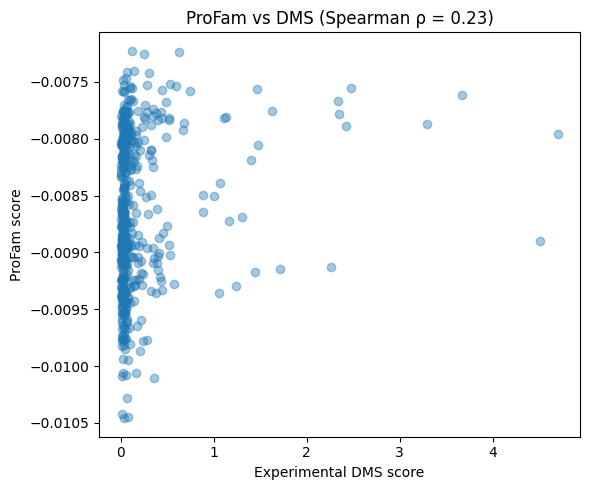

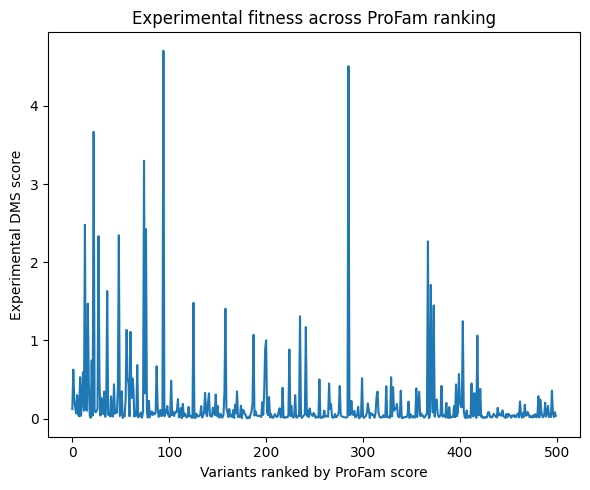

In [38]:
#@title 📊 Evaluate ProFam scores against DMS experimental fitness

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score

# df must already exist from the merge cell
if "df" not in globals():
    raise RuntimeError("Merged dataframe 'df' not found. Run the merge cell first.")

print("Data shape:", df.shape)

# ------------------------------------------------------------------
# 1️⃣ Spearman correlation (continuous DMS score)
# ------------------------------------------------------------------
rho, pval = spearmanr(df["score"], df["DMS_score"])

print("Spearman correlation:")
print(f"  ρ = {rho:.4f}")
print(f"  p-value = {pval:.2e}")
print()

# ------------------------------------------------------------------
# 2️⃣ AUROC (binary functional classification)
# ------------------------------------------------------------------
if "DMS_score_bin" in df.columns:
    auc = roc_auc_score(df["DMS_score_bin"], df["score"])
    print("AUROC (functional vs non-functional):")
    print(f"  AUROC = {auc:.4f}")
    print()
else:
    print("No DMS_score_bin column available for AUROC.\n")

# ------------------------------------------------------------------
# 3️⃣ Scatter plot
# ------------------------------------------------------------------
plt.figure(figsize=(6,5))
plt.scatter(df["DMS_score"], df["score"], alpha=0.4)
plt.xlabel("Experimental DMS score")
plt.ylabel("ProFam score")
plt.title(f"ProFam vs DMS (Spearman ρ = {rho:.2f})")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 4️⃣ Optional: Rank-based view
# ------------------------------------------------------------------
df_sorted = df.sort_values("score", ascending=False).reset_index(drop=True)

plt.figure(figsize=(6,5))
plt.plot(df_sorted["DMS_score"].values)
plt.xlabel("Variants ranked by ProFam score")
plt.ylabel("Experimental DMS score")
plt.title("Experimental fitness across ProFam ranking")
plt.tight_layout()
plt.show()